In [1]:
import torch
import numpy as np
import torchvision
from torchvision import transforms
from pytorch_lightning import Trainer

from matplotlib import pyplot as plt

from datasets import Faces
from cvae import VAE

In [2]:
input_shape = (1, 28, 28)
model = VAE(input_shape, 10, dataset_name='mnist')
trainer = Trainer(gpus=1, max_epochs=10)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


# Logging and visualizations
Model logs losses and recovered images into **TensorBoard**.  
Losses are logged every batch for both train and val datasets.  
Recovered images are logged after each epoch only for images in val dataset.  

In [8]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 16160), started 0:00:01 ago. (Use '!kill 16160' to kill it.)

In [3]:
trainer.fit(model)


  | Name    | Type    | Params
------------------------------------
0 | encoder | Encoder | 10 M  
1 | decoder | Decoder | 5 M   
C:\Users\Sontref\Anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:25: UserWarning: Your val_dataloader has shuffle=True, it is best practice to turn this off for validation and test dataloaders.
  warnings.warn(*args, **kwargs)


1

# Sampling

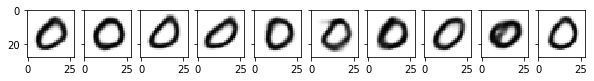

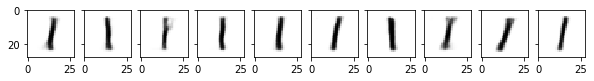

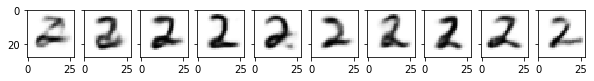

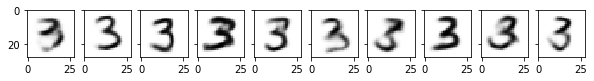

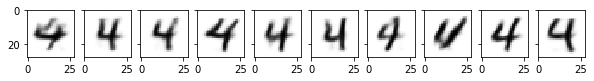

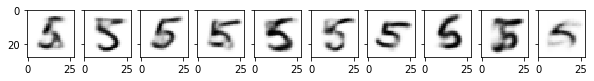

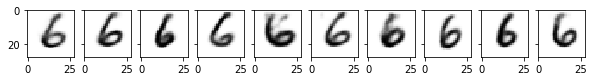

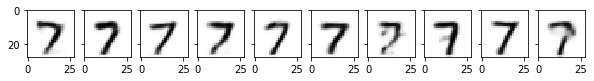

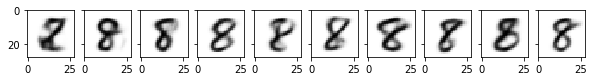

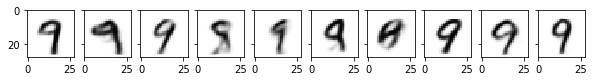

In [7]:
device = 'cuda'

model.eval()
for i in range(10):
    labels = torch.tensor([i]*10).to(device)
    n_images = labels.size()[0]
    rand_features = torch.randn(n_images, 2048).to(device)
    new_images = model.decoder(rand_features, labels)
    
    image_height = input_shape[1]
    image_width = input_shape[2]

    fig, axes = plt.subplots(nrows=1, ncols=n_images, figsize=(10, 2.5), sharey=True)
    decoded_images = new_images[:n_images, 0]

    for ax, img in zip(axes, decoded_images):
        cpu_img = img.detach().to(torch.device('cpu'))
        ax.imshow(cpu_img.view((image_height, image_width)), cmap='binary')
        
    plt.show()

# Latent representation

In [13]:
from torch.utils.data import DataLoader
#transforms_ = transforms.Compose([transforms.ToTensor()])
#dataset = Faces('images/faces/', transforms_=transforms_, img_height=input_shape[1], img_width=input_shape[2])
transforms_ = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.1307,), (0.3081,))])
mnist_train = torchvision.datasets.MNIST('images/mnist', train=True, download=True,
                transform=transforms_)
_, mnist_val = torch.utils.data.random_split(mnist_train, [55000, 5000])
loader = DataLoader(mnist_val, batch_size=1)

In [33]:
latent_vectors = []
labels = []
for img, label in loader:  
    img = img.to('cuda')
    label = label.to('cuda')
    mu, logsigma = model.encoder(img, label)
    latent_vectors.append(model.sampler(mu, logsigma).detach().cpu().numpy().flatten())
    #labels.append(label.detach().cpu().numpy().flatten())
    labels.append(label.item())

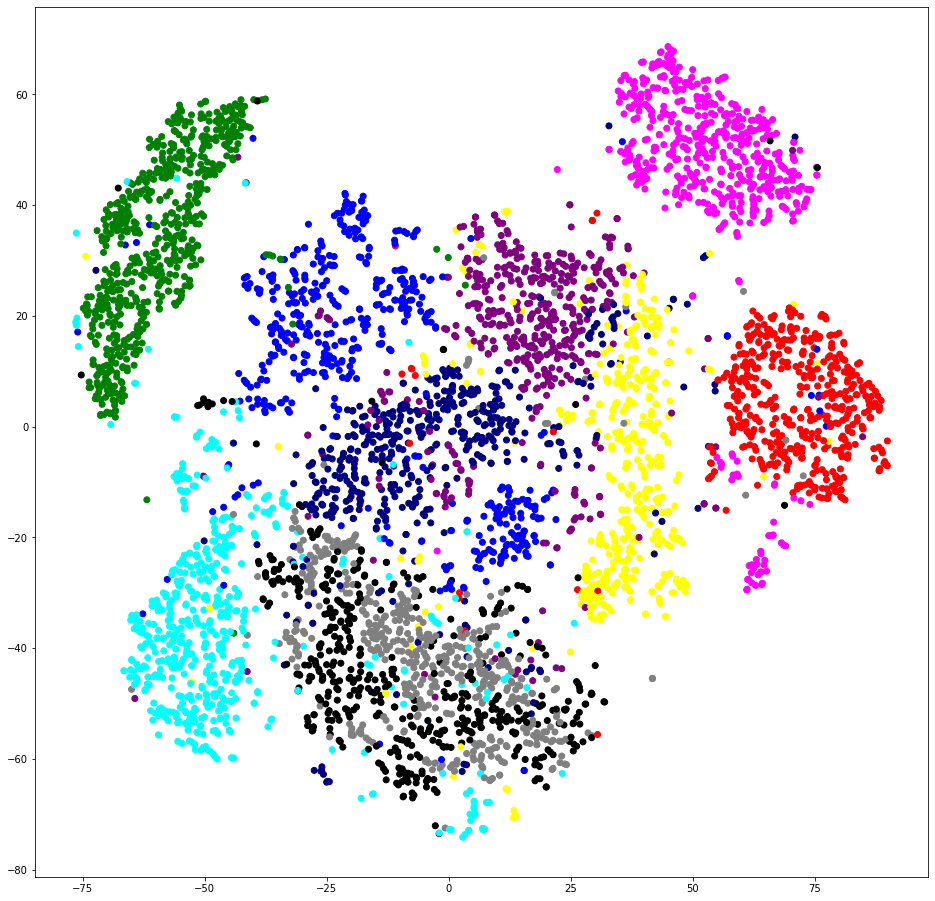

In [35]:
import matplotlib
from sklearn.manifold import TSNE

tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=19)
new_values = tsne_model.fit_transform(latent_vectors)

x = []
y = []
for value in new_values:
    x.append(value[0])
    y.append(value[1])

colors = ['red', 'green', 'blue', 'purple', 'black', 'yellow', 'magenta', 'cyan', 'navy', 'gray']
plt.figure(figsize=(16, 16)) 
plt.scatter(x, y, c=labels, cmap=matplotlib.colors.ListedColormap(colors))
plt.show()

There is a similarity with default VAE representations. Even some clusters are settled on same places. However, (maybe due to low n_iter fo TSNE) here we can see quite more overlapping. Also clusters, despite being clearly seen, are still grouped together. For default VAE they are more distanced.